# Model Training Tutorial

Welcome to the model training tutorial! In this tutorial, we will train a neural network to classify tiles from our toy data set and visualize its efficacy. Our model is essentially a wrapper around PyTorch's ResNet 18 deep residual network; the LUNA team modified it to suit their work with tiling the slides. 


In [1]:
# setup home directory
import os
HOME = os.environ['HOME']

In [2]:
env DATASET_URL=file:///$HOME/vmount/PRO-12-123/

env: DATASET_URL=file:////home/limr/vmount/PRO-12-123/


### Model Training

The model will be used to classify tiles into the different tissue types we've annotated (tumor, stroma and fat). These tissue classifier models can be trained using the `train_tissue_classifier` CLI tool

In [3]:
!train_tissue_classifier --help

2023-04-04 18:31:40,338 - INFO - root - Initalized logger, log file at: luna.log
Usage: train_tissue_classifier [OPTIONS] TILE_DATASET_FPATH

  Train a tissue classifier model for all tiles in a slide

  Inputs:
      tile_dataset_fpath: path to tile dataset parquet table
  
  Outputs:
      ray ExperimentAnalysis dataframe and metadata saved to the output
  
  Example:
      train_tissue_classifier /tables/slides/slide_table
          -ne 5
          -nt torchvision.models.resnet18
          -nw 1
          -o results/train_tile_classifier_results

Options:
  -o, --output_dir TEXT           Path to output directory to save results and
                                  logs from Ray
  -ls, --label_set TEXT           Dictionary/json where keys coorespoond to
                                  tissue types and values coorespond to
                                  numerical values
  -lc, --label_col TEXT           Column name in the input dataframe
                                  coor

This CLI tool has a many command line arguments. The main input is the labled tile dataset, which is the data used to train and valdiate the model. For validation, the tiles are stratified by patient id and by slide id, and the split is contoleled by the `num_splits` parameter. The `label_set` parameter is used to map the tissue types to numerical quantities. These models can use none, one, or many GPUs/CPUs using Ray. The arguments used to modify the resources are `num_gpus, num_cpus, num_workers, num_cpus_per_worker, num_gpus_per_worker`. If you want to experiment with different hyperparameters, you can supply a list of values to certian arguments, such as `learning_rate` or `batch_size` and Ray will perform a hyperparameter search or sweep accordingly. 

In the following example, we're going to train a ResNet18 model (though any model available from [PyTorch](https://pytorch.org/vision/stable/models.html) can be used) for two epochs. 

In [4]:
%%bash

train_tissue_classifier ~/vmount/PRO-12-123/datasets/PRO_TILES_LABELED/segments \
--label_set "{'tumor':0, 'stroma':1, 'fat':2}" \
--label_col regional_label --stratify_col slide_id \
--num_epochs 2 --network 'torchvision.models.resnet18' \
--num_splits 2 \
--batch_size 4 \
-lr 1e-4  \
-cw 4 -gw 0 -nw 1 -ng 0 -nc 5 -ns 1 \
--output_dir ../PRO-12-123/tissue_classifier_results


2023-04-04 18:31:44,554 - INFO - root - Initalized logger, log file at: luna.log
2023-04-04 18:31:44,557 - INFO - luna.common.utils - Started CLI Runner wtih <function train_model at 0x7f1f35cb2670>
2023-04-04 18:31:44,559 - INFO - luna.common.utils - Validating params...
2023-04-04 18:31:44,562 - INFO - luna.common.utils -  -> Set tile_dataset_fpath (<class 'str'>) = /home/limr/vmount/PRO-12-123/datasets/PRO_TILES_LABELED/segments
2023-04-04 18:31:44,566 - INFO - luna.common.utils -  -> Set output_dir (<class 'str'>) = ../PRO-12-123/tissue_classifier_results
2023-04-04 18:31:44,569 - INFO - luna.common.utils -  -> Set label_set (<class 'dict'>) = {'tumor': 0, 'stroma': 1, 'fat': 2}
2023-04-04 18:31:44,571 - INFO - luna.common.utils -  -> Set label_col (<class 'str'>) = regional_label
2023-04-04 18:31:44,573 - INFO - luna.common.utils -  -> Set stratify_col (<class 'str'>) = slide_id
2023-04-04 18:31:44,575 - INFO - luna.common.utils -  -> Set num_splits (<class 'int'>) = 2
2023-04-04 

Result for TorchTrainer_f5502_00000:
  _time_this_iter_s: 75.94302082061768
  _timestamp: 1680633192
  _training_iteration: 1
  date: 2023-04-04_18-33-12
  done: false
  experiment_id: cba2c49339824b0ca538a08eee4ab134
  hostname: 74d50108ecab
  iterations_since_restore: 1
  node_ip: 172.21.0.5
  pid: 458
  time_since_restore: 80.38494443893433
  time_this_iter_s: 80.38494443893433
  time_total_s: 80.38494443893433
  timestamp: 1680633192
  timesteps_since_restore: 0
  train_Accuracy: 0.6581818461418152
  train_F1Score: 0.6581818461418152
  train_Precision: 0.6581818461418152
  train_Recall: 0.6581818461418152
  train_loss: 0.8410024582475856
  training_iteration: 1
  trial_id: f5502_00000
  val_Accuracy: 0.6540229916572571
  val_ConfusionMatrix:
  - - 369
    - 1
    - 161
  - - 28
    - 0
    - 103
  - - 8
    - 0
    - 200
  val_F1Score: 0.6540229916572571
  val_Precision: 0.6540229916572571
  val_Recall: 0.6540229916572571
  val_loss: 0.713255486715961
  warmup_time: 1.6474692821502

(RayTrainWorker pid=517) 2023-04-04 18:34:26,387 - INFO - train_tissue_classifier - Completed model training


Trial TorchTrainer_f5502_00000 completed.


2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - == Status ==
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Current time: 2023-04-04 18:34:29 (running for 00:02:41.80)
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Memory usage on this node: 6.1/20.3 GiB 
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Using FIFO scheduling algorithm.
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Resources requested: 0/5 CPUs, 0/0 GPUs, 0.0/11.81 GiB heap, 0.0/5.91 GiB objects
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Result logdir: /home/limr/vmount/PRO-12-123/tissue_classifier_results/TorchTrainer_2023-04-04_18-31-47
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - Number of trials: 1/1 (1 TERMINATED)
2023-04-04 18:34:29,511 - INFO - train_tissue_classifier - +--------------------------+------------+----------------+--------+------------------+--------------+------------+--------------+
2023-04-04 18:34:29,511 - INF

### Results

Now that we have a trained model, we can inspect the output

In [9]:
%%bash

ls /home/limr/vmount/PRO-12-123/tissue_classifier_results/TorchTrainer_2023-04-04_18-31-47

TorchTrainer_f5502_00000_0_2023-04-04_18-31-47
basic-variant-state-2023-04-04_18-31-47.json
experiment_state-2023-04-04_18-31-47.json
trainable.pkl
tuner.pkl


In [6]:
!ls -lat ../PRO-12-123/tissue_classifier_results

total 87496
-rw-r--r--  1 limr limr    12354 Apr  4 18:34 metadata.yml
drwxr-xr-x  7 limr limr      224 Apr  4 18:34 TorchTrainer_2023-04-04_18-31-47
-rw-r--r--  1 limr limr 44788557 Apr  4 18:34 checkpoint_1.pt
drwxr-xr-x 17 limr limr      544 Apr  4 18:34 .
-rw-r--r--  1 limr limr 44788557 Apr  4 18:33 checkpoint_0.pt
drwxr-xr-x  7 limr limr      224 Apr  4 17:52 TorchTrainer_2023-04-04_17-51-33
drwxr-xr-x  7 limr limr      224 Apr  4 17:46 TorchTrainer_2023-04-04_17-45-03
drwxr-xr-x  7 limr limr      224 Apr  4 17:11 TorchTrainer_2023-04-04_17-10-05
drwxr-xr-x  7 limr limr      224 Apr  4 16:08 TorchTrainer_2023-04-04_16-06-53
drwxr-xr-x  7 limr limr      224 Apr  3 21:43 TorchTrainer_2023-04-03_21-43-48
drwxr-xr-x  7 limr limr      224 Apr  3 21:37 TorchTrainer_2023-04-03_21-37-39
drwxr-xr-x  7 limr limr      224 Apr  3 21:21 TorchTrainer_2023-04-03_21-21-44
drwxr-xr-x  7 limr limr      224 Apr  3 21:09 TorchTrainer_2023-04-03_21-09-44
drwxr-xr-x  6 limr limr      192 Apr  3 21:09 

For every time the model is trained, Ray will put together a set of output directories to manage your runs. You can inspect the results using Ray's ExperimentAnalysis dataframe by loading a particular output directory. This dataframe will store various performance metrics as well as the hyperparameters used to configure the model among other output metadata

In [10]:
from ray.tune import ExperimentAnalysis
RAY_OUTPUT = "TorchTrainer_2023-04-04_18-31-47" # change this to the output folder you want to insepct
output_dir = "../PRO-12-123/tissue_classifier_results"

ray_output_dir = os.path.join(output_dir, RAY_OUTPUT)
analysis = ExperimentAnalysis(ray_output_dir)
display(analysis.results_df)


,train_Accuracy,train_Precision,train_Recall,train_F1Score,train_loss,val_Accuracy,val_Precision,val_Recall,val_F1Score,val_ConfusionMatrix,...,iterations_since_restore,warmup_time,experiment_tag,config/scaling_config/trainer_resources,config/scaling_config/num_workers,config/scaling_config/use_gpu,config/scaling_config/placement_strategy,config/scaling_config/_max_cpu_fraction_per_node,config/scaling_config/resources_per_worker/CPU,config/scaling_config/resources_per_worker/GPU
trial_id,,,,,,,,,,,,,,,,,,,,,
f5502_00000,0.7418182,0.7418182,0.7418182,0.7418182,0.477128,0.6827586,0.6827586,0.6827586,0.6827586,"[[900, 1, 161], [138, 16, 108], [128, 16, 272]]",...,2,1.647469,0,None,1,False,PACK,None,4,0


We can use the output to put together a confusion matrix.


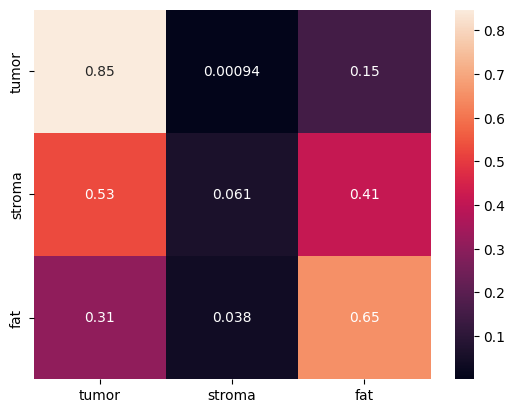

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

label_dict = {'tumor':0, 'stroma':1, 'fat':2}
labels = list(label_dict.keys())
cm = analysis.results_df['val_ConfusionMatrix'].iloc[0]

# normalize 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm
sns.heatmap(df_cm, annot=True)
plt.show()

This output directory directory also contains our model checkpoints `checkpoint_*.pt` that we'll need for inference. Now, with our trained model and model checkpoints, we can move on the next notebook!
